In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from daftpy.daftmodel import (split_data, scores_statistics, metrics_regression, 
                              plot_learning_curves, compare_models, residuals, 
                              transformer_estimator, IdentityTransformer, get_weigts, plot_metrics)
#, transformer_estimator,residuals
from yellowbrick.regressor import ResidualsPlot
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

import joblib

In [86]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# plt.style.use('seaborn')

In [5]:
data = pd.read_csv('data/selected_data.csv', sep=',')
data.shape 

(7344, 9)

In [6]:
# Numeric features
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
#num_features.remove('longitude')
#num_features.remove('latitude')

# Categorical features
cat_features =  list(data.select_dtypes('object').columns)
cat_features.remove('city_district')

# Make DataFrames to present the features
num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

# Merge both DataFrames
feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,place
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


In [77]:
levels_type_house = data.type_house.unique()
levels_place = data.place.unique()
# levels_city_district = data.city_district.unique()
levels_list = [levels_place, levels_type_house]

cat_feat_df['n_levels'] = [levels_place, levels_type_house] #, levels_city_district
cat_feat_df['sample'] = [levels_place[:5], levels_type_house] #, levels_city_district[:4]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,place,"[nan, Naas, Wexford, Dublin 8, Dublin 6W, Carr...","[nan, Naas, Wexford, Dublin 8, Dublin 6W]"
1,type_house,"[house, nan, apartment]","[house, nan, apartment]"


In [8]:
features = [
    'price',
    'floor_area',
    'latitude',
    'longitude',
    'bedroom',
    'bathroom',
    'type_house',
#    'city_district',
    'place']

data = data[features].copy()
data.shape

(7344, 8)

In [11]:
X, y = split_data(data=data, 
                  target='price', 
                  test_size=.15, 
                  output='X_y',
                  random_state=7)

X: (7344, 7)
y: (7344,)


# KMeans

In [16]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [39]:
num_pipe = Pipeline([
            ('power_transformer', StandardScaler()), #PowerTransformer(method='yeo-johnson')
            ('poly', PolynomialFeatures(degree=1, include_bias=False)),
            ('imputer', SimpleImputer(strategy='median')),
            ])
cat_pipe = Pipeline([
            ('one_hot_encoder', OneHotEncoder(categories=levels_list)), 
            ('imputer', SimpleImputer(strategy='constant', fill_value=None)),
            ])
preprocessor = ColumnTransformer([
            ('num', num_pipe, num_features),
            ('cat', cat_pipe, cat_features),
            ])
pipe_estimator = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('cluster', kmeans),
            ])

    
X_transformed = pipe_estimator.fit_transform(X)

In [61]:
max_cluster = 10
inertia_dict = {}
for n_clusters in range(1, max_cluster + 1):
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=7)  #, n_init=10  MiniBatchKMeans
    y_pred = kmeans.fit(X_transformed)
    
    inertia_dict[n_clusters] = kmeans.inertia_
    
    print(n_clusters)
    print(kmeans.inertia_)  
#    print(kmeans.score(X_transformed))
#    print(silhouette_score(X_transformed, kmeans.labels_)) 

1
35600.26439075578
2
22434.504900784745
3
16877.7931649965
4
13528.542297924745
5
10684.625717540393
6
9445.6855045956
7
8449.755581301366
8
7630.730928047858
9
6925.854686846261
10
6367.8230662472115


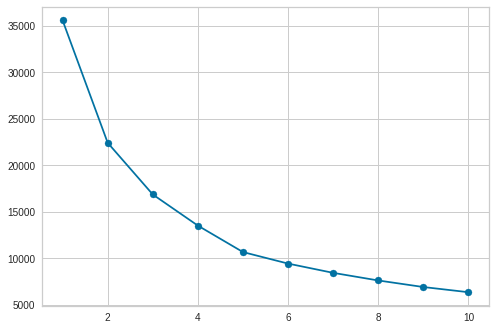

In [76]:
plt.scatter(x=inertia_dict.keys(), y=inertia_dict.values())
plt.plot(inertia_dict.keys(), inertia_dict.values())

In [54]:
# Number of maximum clusters tried 
max_cluster = 10
# Initialise dictionary 
sil_graph = {}
# Looping starting with 2 clusters and then
for cluster in range(2, max_cluster + 1):    
    # Calculate the kmeans with clusters
    kmeans = KMeans(n_clusters=cluster, random_state=7).fit(X_transformed)
    # Calculate the kmeans labels
    sil_graph[cluster] = silhouette_score(X_transformed, kmeans.labels_)
sil_graph

{2: 0.44548964044762773,
 3: 0.29732584283378855,
 4: 0.33040903138148137,
 5: 0.3397067377121687,
 6: 0.303611596138964,
 7: 0.3407526710799161,
 8: 0.30417769915753984,
 9: 0.3034867610768991,
 10: 0.31227503832360637}

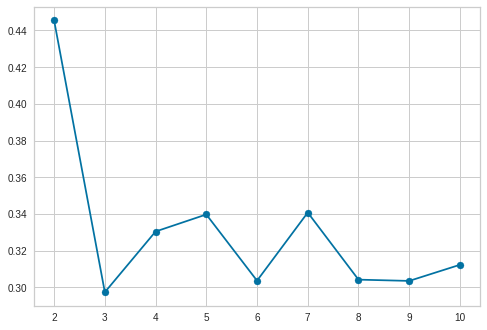

In [75]:
plt.scatter(x=sil_graph.keys(), y=sil_graph.values())
plt.plot(sil_graph.keys(), sil_graph.values())

In [213]:
kmeans = KMeans(n_clusters=2, random_state=7)
y_pred = kmeans.fit_predict(X_transformed)

kmeans.labels_

7344

In [214]:
X['cluster'] = kmeans.labels_

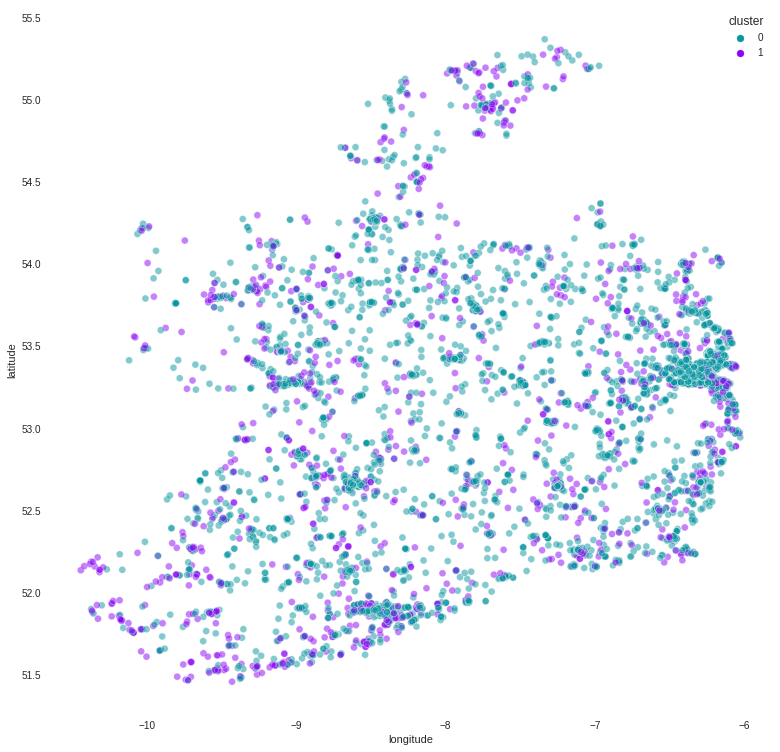

In [216]:
fig, ax = plt.subplots(figsize=(13, 13))

sns.scatterplot(data=X, x='longitude', y='latitude', 
                hue='cluster', ax=ax, 
                palette={-1:'red', 0:'#0896A1', 1:'#8C05F4', 2:'#EE0CBD',
                         3:'#0C15EE', 4:'#0CF631', 5:'#8C05F4', 6:'#8C05F4',
                         7:'red', 8:'#0896A1', 9:'black', 10:'yellow'
                        }, ##8C05F4
                alpha=.5, 
                #size='cluster'
               )  
for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
ax.grid(visible=False)

# DBSCAN

In [79]:
X_transformed.shape, y.shape

((7344, 5), (7344,))

In [81]:
from sklearn.cluster import DBSCAN

In [200]:
epsilon = .43

dbscan = DBSCAN(eps=epsilon, min_samples=7).fit(X_transformed)

print((pd.Series(list(dbscan.labels_)) == -1).sum())
pd.Series(list(dbscan.labels_)).unique()

262


array([ 0, -1,  1,  2,  3,  4])

In [117]:
# Indices of the core components
dbscan.core_sample_indices_

array([   1,    2,    3, ..., 7340, 7341, 7342])

In [119]:
# Core components
dbscan.components_

array([[2.80310577, 2.40964771, 1.25408131, 2.83663484, 2.36397862],
       [2.36206254, 3.264049  , 2.16692614, 2.49984069, 3.85656013],
       [3.22273523, 3.22029091, 1.85269278, 2.61362394, 2.4129351 ],
       ...,
       [6.43993721, 4.86970644, 4.91884291, 5.18882048, 2.5539855 ],
       [4.60905431, 3.96747034, 2.93917765, 3.83397796, 1.44857604],
       [3.71106026, 2.18427886, 2.70876152, 3.20406924, 2.3898342 ]])

In [144]:
dbscan

DBSCAN()

In [137]:
len(dbscan.labels_)

7344

In [145]:
X.shape

(7344, 7)

In [201]:
X['cluster'] = dbscan.labels_
X.shape

(7344, 8)

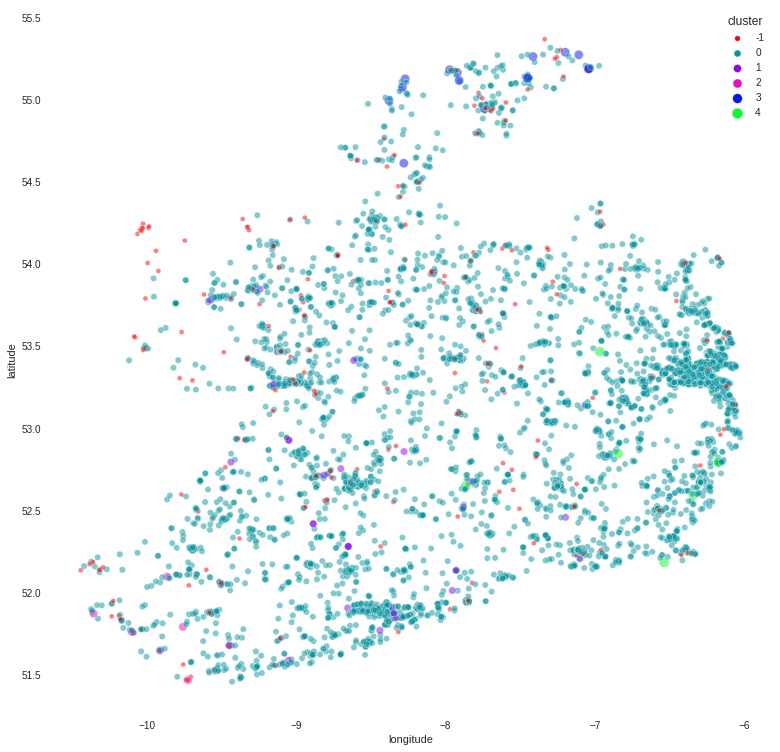

In [209]:
fig, ax = plt.subplots(figsize=(13, 13))

sns.scatterplot(data=X, x='longitude', y='latitude', 
                hue='cluster', ax=ax, 
                palette={-1:'red', 0:'#0896A1', 1:'#8C05F4', 2:'#EE0CBD',
                         3:'#0C15EE', 4:'#0CF631', 5:'#8C05F4', 6:'#8C05F4',
                         7:'red', 8:'#0896A1', 9:'black', 10:'yellow'
                        }, ##8C05F4
                alpha=.5, 
                size='cluster'
               )  
for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)
ax.grid(visible=False)